In [71]:
using LinearAlgebra
using Plots
using Measures
using DelimitedFiles
include("greensfunction.jl")
#using Kronecker
⊗(a,b) = kron(a,b)

⊗ (generic function with 1 method)

In [57]:
μm = 10^-6; GHz = 1; 

"""
Made racetrack_positions and PBC mutable.
racetrack_positions is 2D vector, so that we can duplicate set of racetracks
"""
struct DWLattice
    n_racetracks::Ref{Int} # number of racetracks in the unit cell
    racetrack_positions::Ref{Vector{Float64}}
    orientations::Ref{Vector{Int}} # relative orientation of each domain wall;
    a::Float64 # lattice constant
    γ::Ref{Vector{Float64}} # damping constant for each oscillator
    ω₀::Ref{Vector{Float64}} # resonant frequency of each DW
    PBC::Ref{Bool} # periodic boundary conditions? for k-dependent Hamiltonian?
    C::Float64 # Stray-field coupling constant
    R₀::Float64 # distance between racetracks at which C was calculated
end

function init(; n_racetracks::Int, racetrack_positions::Vector{Float64}, orientations::Vector{Int},
    a::Float64, γ::Vector{Float64}, ω₀::Vector{Float64}, PBC::Bool, C::Float64, R₀::Float64)
return DWLattice(n_racetracks, racetrack_positions, orientations, a, γ, ω₀, PBC, C, R₀);
end

testSystem = DWLattice(2, [0, 2.5]*μm, [1,-1], 5*μm, [0.1,0.1]*GHz, [10,15]*GHz, true, 10^8, 2.5*μm);

In [58]:
function HO_Hamiltonian(ω₀::Float64,γ::Float64)
    H₀ = [0 1; -ω₀^2 -2*γ]
    #display(H₀)
    return H₀
end

function Coupling_Hamiltonian(C::Union{ComplexF64, Float64})
    H = [0 0; C 0]; # adds a term dₜ²x₁ = -ω₀²x₁ - 2γdₜx₁ + C*x₂
    return H
end

function constructHamiltonian(system::DWLattice, NNs::Int)
    function H(k::Union{ComplexF64,Float64})
        H₀ = zeros(ComplexF64,2*system.n_racetracks[],2*system.n_racetracks[])
        # add oscillators on diagonal
        for i = 1:system.n_racetracks[]
            ivec = zeros(system.n_racetracks[]); ivec[i] = 1;
            H₀ += ivec⊗(ivec')⊗HO_Hamiltonian(system.ω₀[][i],system.γ[][i]) 
        end
        # add coupling between oscillators
        for i = 1:system.n_racetracks[]
            for j = ((i-NNs):(i-1))∪((i+1):(i+NNs))
                if(j != i)
                    j_index = mod(j-1, system.n_racetracks[])+1
                    dR = (floor((j-1)/system.n_racetracks[]))*system.a # distance of nth unit cell away
                    ΔR = abs(system.racetrack_positions[][i] - (dR + system.racetrack_positions[][j_index])) # distance of nth racetrack
                    # make huge approximation here, say that Cij decays with 1/r² from calculated
                    # may need minus sign
                    Cij = system.orientations[][i][]*system.orientations[][j_index][]*system.C*(system.R₀/ΔR)^(2)
                    Hindex = zeros(system.n_racetracks[],system.n_racetracks[]); Hindex[i,j_index] = 1
                    #println("i = $(i), j = $(j), J_index = $(j_index)")
                    if(j < 1 || j > system.n_racetracks[])
                        if(system.PBC[])
                            H₀ += Hindex⊗Coupling_Hamiltonian(Cij*exp(im*k*dR))
                            #println("k⋅dR/(2π) = $(k*dR/(2*π))")
                        end
                    else
                        H₀ += Hindex⊗Coupling_Hamiltonian(Cij)
                    end
                end
            end
        end
        #display(H₀)
        return H₀
    end
    return H
end

constructHamiltonian (generic function with 1 method)

In [59]:
H_AFM_racetrack = constructHamiltonian(testSystem,2)

(::var"#H#56"{DWLattice, Int64}) (generic function with 1 method)

In [60]:
function plot1DBands(H::Function,system::DWLattice,nk::Int,Broadening::Bool=false, nE::Int = 200, DOS=true)
    a = system.a
    kvals = LinRange(-π/a,π/a,nk)
    ys = []
    xs = []
    maxE = maximum(imag.(eigvals(H(π/a)) ∪ eigvals(H(0.0))))
    if(Broadening)
        # get some reasonable maximum for the energies
        Evals = LinRange(0,maxE*1.1,nE)
        n = 2*system.n_racetracks[]
        bands = zeros(nk,nE)
        plottingBands = zeros(nk,nE)
        @Threads.threads for ik in eachindex(kvals)
            k = kvals[ik]
            Hatk = H(k)
            DOS_k(E) = (-1/π)imag.(tr(inv(E*I(n) - im*Hatk)))
            DOS_k_E = DOS_k.(Evals)
            bands[ik,:] = DOS_k_E
        end
        bands = (1/maximum(bands))*bands
        fig = heatmap(kvals*(a/π), Evals, bands', clims=(0,maximum(bands)), xlabel="k (π/a)", ylabel="Frequency (GHz)")
    end
    @Threads.threads for k in kvals
        Es = imag(eigvals(H(k)))
        append!(ys,Es/GHz)
        append!(xs,k*ones(size(Es)))
    end
    fig = scatter!(xs*(a/π),ys, legend=false,ylims=(-0.001,maxE*1.1), xlims=(-1,1), c="white", markersize=2.0, markerstrokewidth=0)
    if(DOS)
        DOS_tot = [sum(bands[:,iE]) for iE = 1:nE]; DOS_tot = (1/maximum(DOS_tot))*DOS_tot
        fDOS = plot(DOS_tot,Evals,legend=false,xlabel="DOS(ω)", ylabel="Frequency (GHz)",ylims=(-0.0001,maxE*1.1),xlims=(0,1))
    end
    fig2 = plot(fig,fDOS,layout=grid(1,2, widths=(5/8,3/8)), size=(800,300),margin=5mm)
    return fig2
end

function getBands(system::DWLattice,NNs::Int,broadening::Bool=false)
    H = constructHamiltonian(system,NNs)
    fig = plot1DBands(H,system,200,broadening)
    #display(fig)
end

getBands (generic function with 2 methods)

In [61]:
AFM2R_lattice = init(n_racetracks=2, racetrack_positions=[0, 2.6]*μm, orientations=[1,-1], 
    a=5*μm, γ=0.5*[1,1]*GHz, ω₀=1.0*[9,8]*GHz, PBC=true, C=10.0*GHz, R₀=2.5*μm);

AFM3R_lattice = init(n_racetracks=3, racetrack_positions=[0, 2.8, 5.0]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.5*[1,0.5,1]*GHz, ω₀=10*[0,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);

FM1R_lattice = init(n_racetracks=1, racetrack_positions=[0]*μm, orientations=[1], 
    a=5*μm, γ=0.5*[1]*GHz, ω₀=10*[2.0]*GHz, PBC=true, C=80.0*GHz, R₀=2.5*μm);


In [62]:
"""
Making supercell.
Modify: n_racetracks, racetrack_positions, orientation, γ, ωₒ
(Ones that are vectors)
"""
function realSpaceArray(unit_cell::DWLattice, num::Int)
    # Shallow copy, creating alias
    orig_racetrack = unit_cell.racetrack_positions[]
    orig_orientations = unit_cell.orientations[]
    orig_γ = unit_cell.γ[]
    orig_ω₀ = unit_cell.ω₀[]

    # Duplicate unit_cell to make supercell.
    dup_lattice = deepcopy(unit_cell)
    dup_lattice.PBC[] = false

    for i = 1:(num-1)
        for j = 1:unit_cell.n_racetracks[]
            new_race = i*unit_cell.a + orig_racetrack[j]
            push!(dup_lattice.racetrack_positions[], new_race)
            push!(dup_lattice.orientations[], orig_orientations[j])
            push!(dup_lattice.γ[], orig_γ[j])
            push!(dup_lattice.ω₀[], orig_ω₀[j])
        end
    end

    # Increase n_racetracks accordingly
    dup_lattice.n_racetracks[] = num * unit_cell.n_racetracks[]

    return dup_lattice
end

realSpaceArray

In [63]:
realSpaceArray(AFM2R_lattice, 2)

DWLattice(Base.RefValue{Int64}(4), Base.RefValue{Vector{Float64}}([0.0, 2.6e-6, 4.9999999999999996e-6, 7.6e-6]), Base.RefValue{Vector{Int64}}([1, -1, 1, -1]), 4.9999999999999996e-6, Base.RefValue{Vector{Float64}}([0.5, 0.5, 0.5, 0.5]), Base.RefValue{Vector{Float64}}([9.0, 8.0, 9.0, 8.0]), Base.RefValue{Bool}(false), 10.0, 2.4999999999999998e-6)

In [77]:
"""
Return transfer function
    @params
    Gʳ (Green's Function)
    race_i (racetrack being perturbed)
    race_j (racetrack being affected)

Includes the creation of supercell
"""
function transferFunc(system::DWLattice, n_lattice::Int, race_i::Int, race_j::Int, startP::Float64, endP::Float64, step::Int, NNs::Int=500)
    # Configure the lattice
    new_sys = realSpaceArray(system, n_lattice)
    Gʳ = genGʳ_nok(constructHamiltonian(new_sys, NNs))

    # local function that returns transfer function
    function T(ω::Float64)
        Gʳ_val = Gʳ(ω)
        return Gʳ_val[2*race_i-1, 2*race_j-1] / Gʳ_val[2*race_i-1, 2*race_i-1]
    end

    # ω and corresponding transfer function value
    ω_total = LinRange(startP, endP, step)
    mag::Vector = (abs∘T).(ω_total)
    ϕ::Vector = (angle∘T).(ω_total)

    return ω_total, mag, ϕ
end

transferFunc

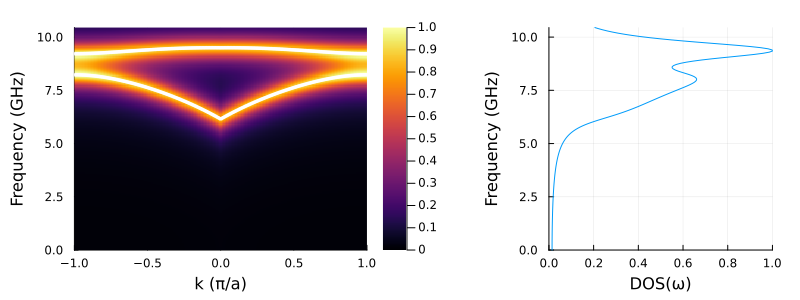

In [65]:
getBands(AFM2R_lattice,200,true)

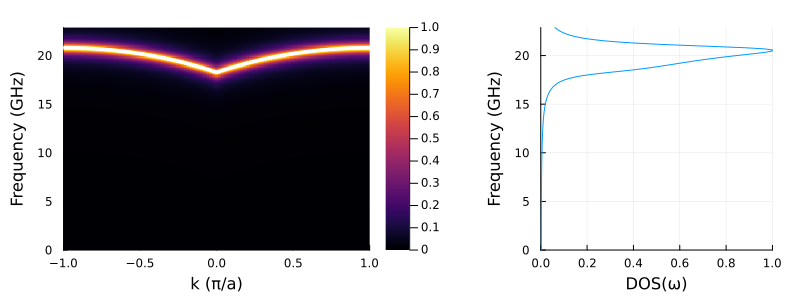

In [66]:
getBands(FM1R_lattice,2000,true)

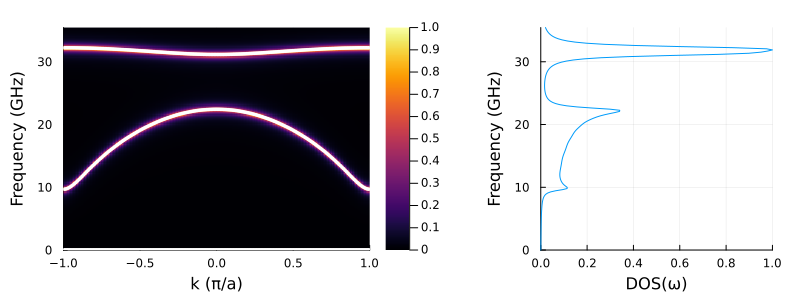

In [67]:
getBands(AFM3R_lattice,50,true)
#plot1DBands(H_AFM_racetrack,testSystem,500,false)
#plot1DBands(H_AFM_racetrack,testSystem,500,true,500)

In [68]:
pinningSweep = @animate for ω₀ in 5*collect(sin.(LinRange(0,π,100)))
    AFM3R_lattice = init(n_racetracks=3, racetrack_positions=[0, 2.8, 5.0]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.7*[1,0.5,1]*GHz, ω₀=10*[ω₀,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);
    getBands(AFM3R_lattice,50,true);
end

Animation("/tmp/jl_47G9a0", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

[ Info: Saved animation to /home/jiwoop/rnf/dwlattice/anim_fps15.gif


Plots.AnimatedGif("/home/jiwoop/rnf/dwlattice/anim_fps15.gif")
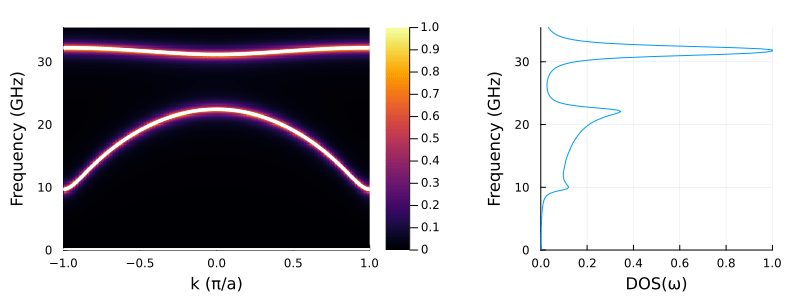

In [69]:
gif(pinningSweep, "anim_fps15.gif", fps = 20)

In [72]:
ω_val, mag, ϕ = transferFunc(AFM2R_lattice, 5, 1, 10, 0.0*GHz, 15.0*GHz, 200)

(LinRange{Float64}(0.0, 15.0, 200), [0.0040193209461207155, 0.0040199821182108535, 0.0040219668458338406, 0.004025278768317031, 0.004029923968812722, 0.004035911000852678, 0.004043250925815403, 0.004051957361601252, 0.004062046542901, 0.004073537393538777  …  0.0006568709569767719, 0.0006495420806554957, 0.0006423308794691992, 0.0006352351651239936, 0.0006282527774701464, 0.0006213815860917509, 0.0006146194916254673, 0.0006079644268391681, 0.0006014143574978699, 0.0005949672830413929], [3.141592653589793, -3.1393819506796405, -3.137169327662571, -3.134952859278813, -3.132730609935245, -3.1305006284693833, -3.1282609428294745, -3.126009554641567, -3.1237444336334224, -3.121463511883839  …  -0.0746119099597261, -0.07424462763419354, -0.07387771652486089, -0.07351140904878033, -0.07314591569000985, -0.07278142695175151, -0.07241811512080162, -0.07205613586424976, -0.07169562967602666, -0.07133672318886229])

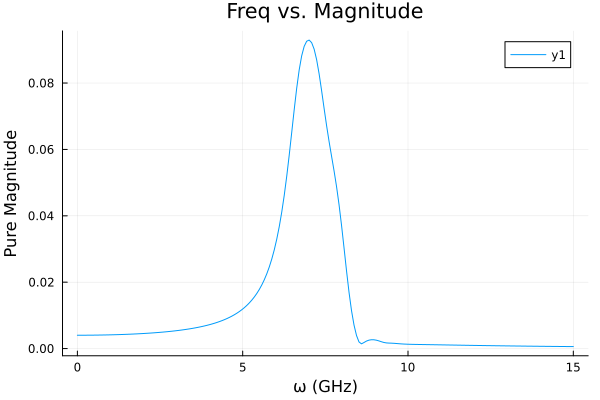

In [73]:
# Original Plot
plot(ω_val, mag)
title!("Freq vs. Magnitude")
xlabel!("ω (GHz)")
ylabel!("Pure Magnitude")

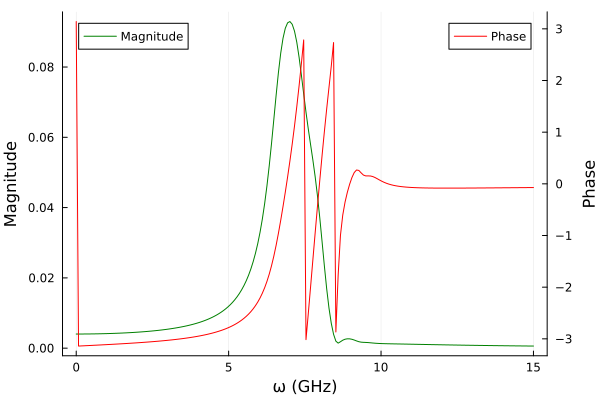

In [75]:
# 2-axis plot | Magnitude & Phase
plot(ω_val, mag, color=:green, label="Magnitude", xlabel="ω (GHz)", ylabel="Magnitude", legend=:topleft)
plot!(twinx(), ω_val, ϕ, color=:red, label=:"Phase", ylabel="Phase")

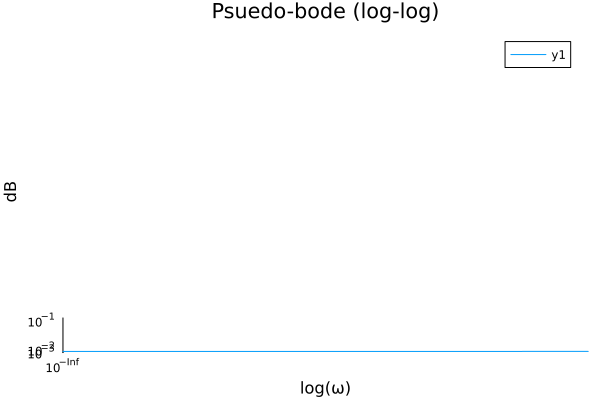

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


In [76]:
# Log-log plot
# x axis scale is much smaller.
plot(ω_val, mag)
plot!(xscale=:log10, yscale=:log10)
title!("Psuedo-bode (log-log)")
xlabel!("log(ω)")
ylabel!("dB")